# Notebook 2: Ecuaciones clásicas de Euler: Modelo base - Fixed same weights

## 1. Introducción

En este notebook usaremos una red neuronal PINN para obtener una solución numérica de las ecuaciones clásicas de Euler, con el modelo de PINNS más básico.

Las ecuaciones clásicas de euler se pueden expresar mediante el siguiente sistema de ecuaciones explícito:

$$
(1)\:\:\:\partial_{t}\rho+u\partial_{x}\rho+\rho\partial_{x}u=0
$$

$$
(2)\:\:\:\rho\left(\partial_{t}u+u\partial_{x}u\right)+\partial_{x}p=0
$$

$$
(3)\:\:\:\partial_{t}p+\gamma p\partial_{x}u+\partial_{x}p=0
$$


Donde $\rho$, $p$ y $u$ corresponden a la densidad, presión y velocidad del fluido respectivamente. Donde $\gamma=1.4$ se define como el coeficiente de dilatación adiabática. Por lo que se trata de un problema de Riemann, un problema de ecuaciones en derivadas parciales de primer orden donde las condiciones iniciales en $t=0$ presentan una discontinuidad. Las condiciones iniciales son las siguientes:

$$
\text{Condiciones iniciales ($t=0$)}=  \left\{
\begin{array}{ll}
      \rho_{0}:\:\:\rho=1.0 & \text{si $x\leq 0.5$ y $\rho=0.125$ si no} \\
      p_{0}:\:\:p=1.0 & \text{si $x\leq 0.5$ y $p=0.1$ si no} \\
      u_{0}:\:\:u=0 & \forall x\\
\end{array} 
\right.
$$

El método usado creará una aproximación a la solución usando una red neuronal. Definiendo $\textbf{U}=(\rho,p,u)$ como el vector de variables

$$
\textbf{U}_{\theta}(t,x)\approx\textbf{U}(t,x),
$$

donde $\theta$ representa los parámetros internos de la red. Tenemos entonces $\textbf{U}_{\theta}(t,x):\:[0,T]\times\Omega\rightarrow\mathbb{R}$, donde $T$ es el tiempo final y $\Omega\subset\mathbb{R}^{d}$ representa el dominio espacial acotado ($d$ corresponde al número de dimenciones espaciales, igual a 1 en nuestro caso). También tendremos condiciones de contorno que se aplican en el dominio espacial acotado, es decir, $\partial\Omega$ (el espacio *tangente*).

Podemos resumir el entrenamiento de la PINN como la optimización de la función de pérdida de la misma. En nuestro caso:

$$
L_{\theta}(X)\equiv L_{\theta}^{r}(X^{r})+L_{\theta}^{0}(X^{0})+L_{\theta}^{b}(X^{b}),
$$

donde $L_{\theta}^{r}$ representa la pérdida residual, $L_{\theta}^{0}$ la pérdida de los datos iniciales y $L_{\theta}^{b}$ es la pérdida relacionada con las condiciones de contorno. Por lo que, $X^{r}$, $X^{0}$ y $X^{b}$ corresponden a los datos de dichos espacios (coordenadas espacio-temporales). En nuestro caso $L_{\theta}^{b}(X^{b})$ será omitido. Las pérdidas se calcularán con de error cuadrático medio. Además añadiendo pesos a las pérdidas:

$$
L_{\theta}(X)\equiv \alpha L_{\theta}^{r}(X^{r})+\beta L_{\theta}^{0}(X^{0})
$$

Pero al tratarse del modelo más básico estos pesos pueden obviarse ya que ambos serán igual a 1.

## 2. Set up

### 2.1. Librerías

In [1]:
# Sytsem
import os
from os import getcwd, listdir
import sys

# Numeric wrangling
import numpy as np
import math
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Problem
from scripts.SodTube import create_dataset #from script

# Models
import tensorflow as tf
from scripts.UVPINNS import PINN #from script

# Saving data
import h5py

# Plots
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Progress display
from tqdm import tqdm

2022-08-26 13:02:20.152354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Prequest size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Grequest size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen

### 2.2. Settings

In [2]:
run_animation = False

In [3]:
# Set data type:
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
# GPU settings
print("Is Tensorflow using GPU? ", tf.test.is_gpu_available())
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is Tensorflow using GPU?  True


2022-08-26 13:02:22.236542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-26 13:02:22.238412: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-26 13:02:22.239544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-26 13:02:22.317942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-26 13:02:22.317987: I tensorflow/stream_executor/platform/default/

### 2.3. Constantes

Aquí elegiremos entre otras cosas la semilla, así como el tamaño de los datos que generaremos.

In [5]:
# Choose the random seed for repudctible results
seed = 0

# Set constants
gamma = 1.4

# Data size generation
N_0, N_r = 5000, 25000

# Problem boundaries
xmin, xmax = 0.0, 1.0
tmin, tmax = 0.0, 0.2

### 2.4. Funciones

In [6]:
def RMSE(x, y):
    return np.sqrt(np.mean(np.sum((x - y) ** 2)))

## 3. Datos

Creamos el conjunto de datos que usaremos:

In [7]:
X_r, X_0, U_0 = create_dataset(xmin, xmax, tmin, tmax, N_r, N_0, seed)

print(X_r.shape)
print(X_0.shape)

2022-08-26 13:02:23.038885: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-26 13:02:23.040023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-26 13:02:23.040076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-26 13:02:23.040106: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-26 13:02:23.040120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-08-26 13:02:23.040133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022

(25000, 2)
(5000, 2)


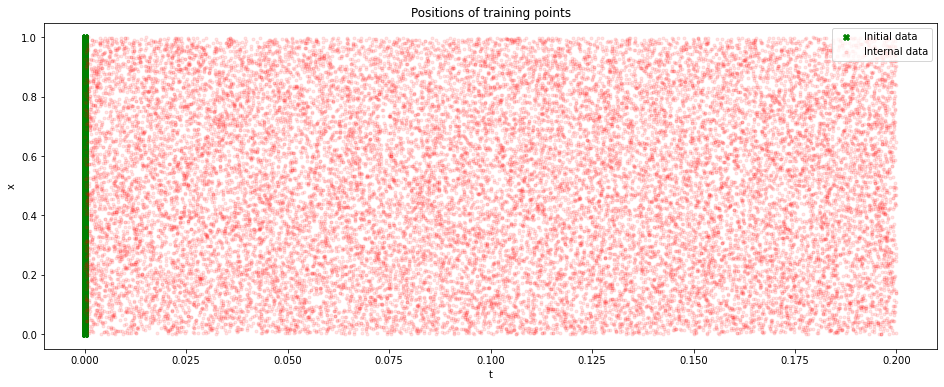

In [8]:
fig = plt.figure(figsize=(16, 9/1.5))
plt.scatter(X_0[:,0], X_0[:,1], c = "g", marker = "X", vmin = -1, vmax = 1, label = "Initial data")
plt.scatter(X_r[:,0], X_r[:,1], c = "r", marker = ".", alpha = 0.1, label = "Internal data")
plt.legend()
plt.xlabel("t")
plt.ylabel("x")

plt.title("Positions of training points")
plt.show()

## 4. Entrenamiento

Ajustamos un learning rate variable, el número de épocas y el optimizador.

In [9]:
# Set learning rate
lr_w = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000,10000,15000,35000],[5e-4,1e-4,5e-5,5e-6,5e-7])
optim_w = tf.keras.optimizers.Adam(learning_rate=lr_w)

# Epochs
epochs = 50000

# Losses list
loss_hist, loss_r_hist, loss_ic_hist = [], [], []
losses_list = [loss_hist, loss_r_hist, loss_ic_hist]

# Variables for plotting
t_plot = tf.reshape(tf.repeat(tmax, N_r), shape = (-1,1))
x_plot = tf.reshape(np.linspace(0.0, 1.0, N_r), shape = (-1,1))

# Predictions list
if run_animation:
    predictions_by_epoch = []

In [10]:
model = PINN(alpha=0.1, beta=10)

In [11]:
model.train_epochs(X_r, X_0, U_0, optim_w, epochs, losses_list)

  0%|                                                 | 0/50000 [00:00<?, ?it/s]2022-08-26 13:02:24.852168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
100%|█| 50000/50000 [41:18<00:00, 20.17it/s, Loss=0.00689, Loss R=0.0491, Loss I


## 5. Resultados

Visualizamos las funciones de pérdida:

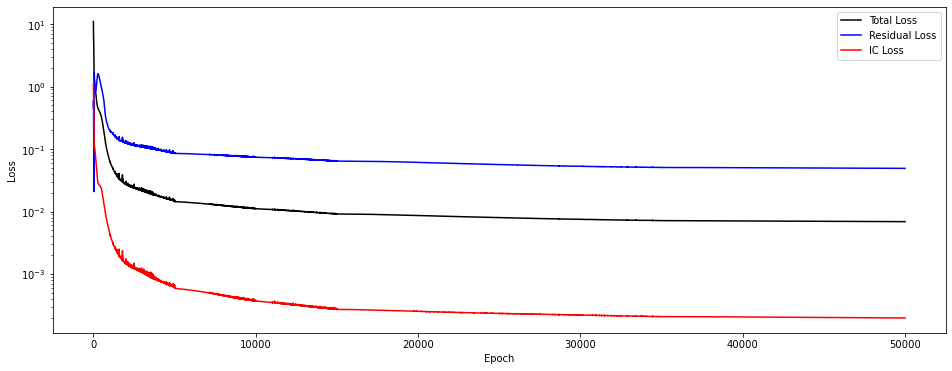

In [12]:
fig = plt.figure(figsize=(16,9/1.5))
ax = fig.add_subplot(111)
ax.semilogy(range(len(loss_hist)), loss_hist, "k-", label = "Total Loss")
ax.semilogy(range(len(loss_r_hist)), loss_r_hist, "b-", label = "Residual Loss")
ax.semilogy(range(len(loss_ic_hist)), loss_ic_hist, "r-", label = "IC Loss")
plt.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.savefig("figs/Losses.png")
plt.show()

Cargamos la solución numerica para poder comparar:

In [13]:
# Load numerical resolution:
hf = h5py.File("../data/Pyclaw_Classical_Euler_1D_Sod_Tube.h5", "r")
print(hf.keys())
x_PC = np.array(hf.get("x"))
t_PC = np.array(hf.get("times"))
e_PC = np.array(hf.get("e_evolved"))
j_PC = np.array(hf.get("j_evolved"))
rho_PC = np.array(hf.get("rho_evolved"))
hf.close()

e_PC_02 = e_PC[e_PC.shape[0]-1,:]
j_PC_02 = j_PC[j_PC.shape[0]-1,:]
rho_PC_02 = rho_PC[rho_PC.shape[0]-1,:]
u_PC_02 = j_PC_02/rho_PC_02
p_PC_02 = (gamma-1)*(e_PC_02 - 0.5*(j_PC_02**2)/rho_PC_02)

<KeysViewHDF5 ['e_evolved', 'j_evolved', 'rho_evolved', 'times', 'x']>


Visualizamos la diferencia numérica:

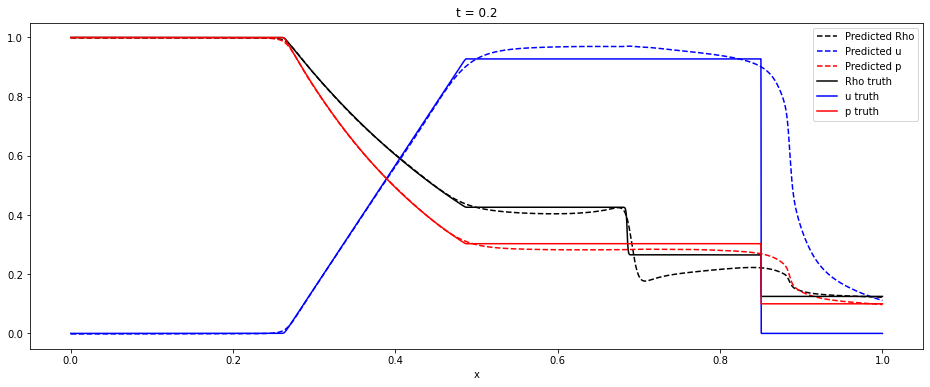

In [14]:
t_plot = tf.reshape(tf.repeat(tmax, N_r), shape = (-1,1))
x_plot = tf.reshape(np.linspace(0.0, 1.0, N_r), shape = (-1,1))

pred = model(tf.concat([t_plot, tf.cast(x_plot, "float32")], axis = 1))
rho_pred, u_pred, p_pred = pred[:,0:1], pred[:,1:2], pred[:,2:3]


plt.figure(figsize = (16,9/1.5))
plt.plot(x_plot, rho_pred, "k--", label = "Predicted Rho")
plt.plot(x_plot, u_pred, "b--", label = "Predicted u")
plt.plot(x_plot, p_pred, "r--", label = "Predicted p")
plt.plot(x_PC, rho_PC_02, "k-", label = "Rho truth")
plt.plot(x_PC, u_PC_02, "b-", label = "u truth")
plt.plot(x_PC, p_PC_02, "r-", label = "p truth")
plt.xlabel("x")
plt.title("t = " + str(tmax))
plt.legend()
plt.savefig("figs/Euler_1D_solution_final_time.png")
plt.show()

Creamos animación evolución de las predicciones:

In [15]:
if run_animation:
    predictions_by_epoch = tf.stack(predictions_by_epoch, axis = 0)

    interval = 50

    x = x_plot
    print(x.shape)

    y = predictions_by_epoch
    print(y.shape)

    fig, ax = plt.subplots(figsize = (16,9/1.5))
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.25)
    graph_1, = plt.plot([], [], "k--", label = "Predicted Rho")
    graph_2, = plt.plot([], [], "k-", label = "Rho truth")
    graph_3, = plt.plot([], [], "b--", label = "Predicted u")
    graph_4, = plt.plot([], [], "b-", label = "u truth")
    graph_5, = plt.plot([], [], "r--", label = "Predicted p")
    graph_6, = plt.plot([], [], "r-", label = "p truth")
    plt.xlabel("x")

    title = ax.text(0.5,1.10, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                    transform=ax.transAxes, ha="center")

    def init():
        return graph_1,

    def animate(i):
        graph_1.set_data(x, y[i,:,0:1])
        graph_2.set_data(x_PC, rho_PC_02)
        graph_3.set_data(x, y[i,:,1:2])
        graph_4.set_data(x_PC, u_PC_02)
        graph_5.set_data(x, y[i,:,2:3])
        graph_6.set_data(x_PC, p_PC_02)
        title.set_text("Epoch " + str(list(range(0, predictions_by_epoch.shape[0]))[i]))
        return graph_1, title

    plt.legend()

    ani = FuncAnimation(fig, animate, frames=range(0, y.shape[0], 50), interval = interval,
                        init_func=init, blit=True)
    ani.save("figs/Euler_Animation.gif", writer='PillowWriter')

    t_plot = tf.reshape(tf.repeat(tmax, N_r), shape = (-1,1))
    x_plot = tf.reshape(np.linspace(0.0, 1.0, N_r), shape = (-1,1))

    pred = model(tf.concat([t_plot, tf.cast(x_plot, "float32")], axis = 1))
    rho_pred, u_pred, p_pred = pred[:,0:1], pred[:,1:2], pred[:,2:3]

Ahora calculamos los errores:

In [16]:
# Construct points and detect with NNs:
x_model = tf.constant(np.linspace(xmin, xmax, x_PC.shape[0]), dtype = DTYPE)
t_model = tf.constant(np.array([tmax for i in range(x_PC.shape[0])]), dtype = DTYPE)

x_model = tf.reshape(x_model, shape = (x_model.shape[0], 1))
t_model = tf.reshape(t_model, shape = (t_model.shape[0], 1))

X_r = tf.concat([t_model, x_model], axis = 1)

# Predictions of model
pred = model(X_r)
rho_model, u_model, p_model = pred[:,0], pred[:,1], pred[:,2]

In [17]:
tests = ["PINN"]
RMSE_rho = [RMSE(rho_PC_02, rho_model)]
RMSE_u = [RMSE(u_PC_02, u_model)]
RMSE_p = [RMSE(p_PC_02, p_model)]

df = pd.DataFrame({"Test": tests, "RMSE_rho": RMSE_rho, "RMSE_u": RMSE_u, "RMSE_p": RMSE_p})
df

,Test,RMSE_rho,RMSE_u,RMSE_p
0,PINN,2.754302,16.102886,2.877498


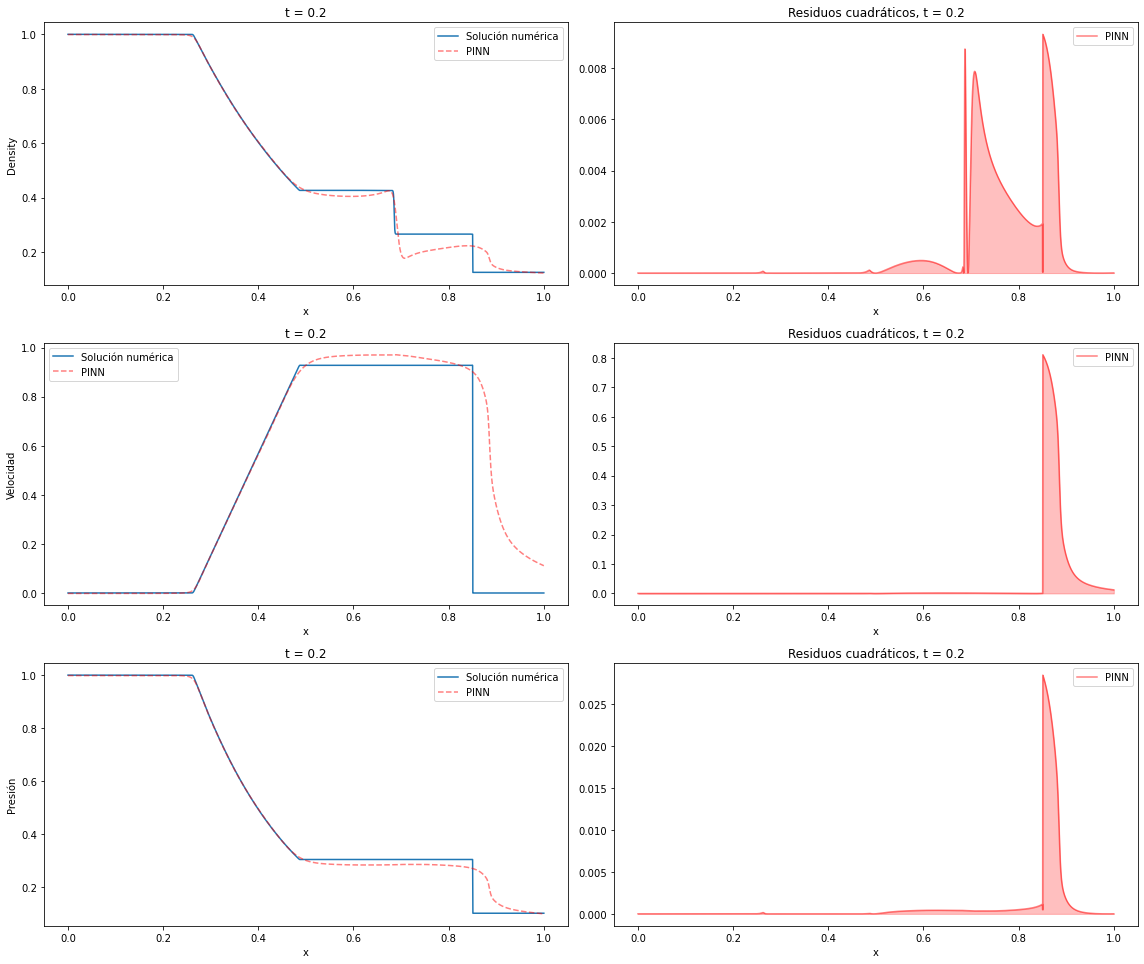

In [18]:
# Comparative plot:
fig, ax = plt.subplots(3,2, figsize=(16,9*1.5))

ax[0,0].plot(x_model, rho_PC_02, label='Solución numérica')
ax[0,0].plot(x_model, rho_model, "r--", alpha = 0.5, label='PINN')
ax[0,0].legend()
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("Density")
ax[0,0].set_title("t = 0.2")

ax[0,1].plot(x_model, (rho_model - rho_PC_02) ** 2, "r", alpha = 0.5, label = "PINN")
ax[0,1].fill_between(x_model.numpy().squeeze(), ((rho_model - rho_PC_02) ** 2).numpy().squeeze(), color = "r", alpha = 0.25)
ax[0,1].legend()
ax[0,1].set_xlabel("x")
ax[0,1].set_title("Residuos cuadráticos, t = 0.2")

ax[1,0].plot(x_model, u_PC_02, label='Solución numérica')
ax[1,0].plot(x_model, u_model, "r--", alpha = 0.5, label='PINN')
ax[1,0].legend()
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("Velocidad")
ax[1,0].set_title("t = 0.2")

ax[1,1].plot(x_model, (u_model - u_PC_02) ** 2, "r", alpha = 0.5, label = "PINN")
ax[1,1].fill_between(x_model.numpy().squeeze(), ((u_model - u_PC_02) ** 2).numpy().squeeze(), color = "r", alpha = 0.25)
ax[1,1].legend()
ax[1,1].set_xlabel("x")
ax[1,1].set_title("Residuos cuadráticos, t = 0.2")

ax[2,0].plot(x_model, p_PC_02, label='Solución numérica')
ax[2,0].plot(x_model, p_model, "r--", alpha = 0.5, label='PINN')
ax[2,0].legend()
ax[2,0].set_xlabel("x")
ax[2,0].set_ylabel("Presión")
ax[2,0].set_title("t = 0.2")

ax[2,1].plot(x_model, (p_model - p_PC_02) ** 2, "r", alpha = 0.5, label = "PINN")
ax[2,1].fill_between(x_model.numpy().squeeze(), ((p_model - p_PC_02) ** 2).numpy().squeeze(), color = "r", alpha = 0.25)
ax[2,1].legend()
ax[2,1].set_xlabel("x")
ax[2,1].set_title("Residuos cuadráticos, t = 0.2")

fig.tight_layout()
plt.savefig("figs/Sod_Problem_Euler_1D_Eqs_solutions.png")
plt.show()

## 6. Guardado de resultados

In [19]:
model.save("models/model", save_format = "tf")

hf = h5py.File("data/data.h5", "w")
hf.create_dataset("X_r", data = X_r.numpy())
hf.create_dataset("X_0", data = X_0.numpy())
hf.create_dataset("rho_ic", data = U_0[0].numpy())
hf.create_dataset("u_ic", data = U_0[1].numpy())
hf.create_dataset("p_ic", data = U_0[2].numpy())
hf.create_dataset("t_plot", data = t_plot.numpy())
hf.create_dataset("x_plot", data = x_plot.numpy())
hf.create_dataset("rho_pred", data = rho_pred.numpy())
hf.create_dataset("u_pred", data = u_pred.numpy())
hf.create_dataset("p_pred", data = p_pred.numpy())
hf.create_dataset("loss_hist", data = np.array(loss_r_hist))
hf.create_dataset("loss_r_hist", data = np.array(loss_r_hist))
hf.create_dataset("loss_ic_hist", data = np.array(loss_ic_hist))
hf.close()

2022-08-26 13:43:47.221799: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model/assets
